# Feature Extraction and Transformation Pipeline

This notebook demonstrates the process of feature extraction, clustering, histogram creation, and IDF computation using custom transformers and pipelines.

In [13]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from classes.feature_extractor import FeatureExtractor
from classes.clusterer import Clusterer
from utilities import utils, process, modify, evaluate, plot
import joblib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import random

random.seed(42)
np.random.seed(42)

## Data Preprocessing

In this step, image resizing and thresholding were performed to standardize the input images for further processing.


In [ ]:

# Specify the source and target directories
source_directory = os.path.join('data', 'isolated_words_per_user')
target_directory = os.path.join('data', 'original')

# Collect images
utils.collect_images_and_copy_to_original(source_directory, target_directory)

# Specify the source and target directories
source_directory = os.path.join('data', 'original')
target_directory = os.path.join('data', 'preprocessed')

# Preprocess images
utils.preprocess_images(source_directory, target_directory)

## Comparing original and preprocessed

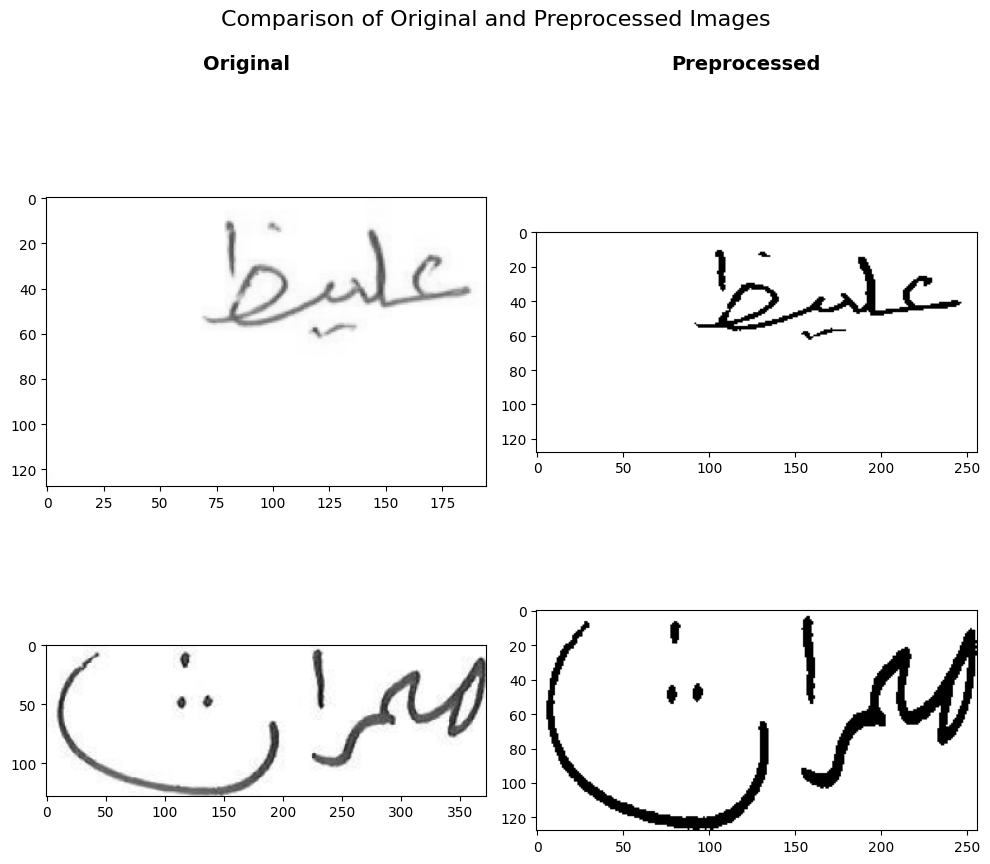

In [14]:
plot.plot_random_images('data/original', 'data/preprocessed', 2)

Visualizing preprocessed images

## Data Preparation

Load images, create a DataFrame, encode labels, and split the data into training and testing sets.

In [2]:
df = utils.load_images_to_dataframe('data/preprocessed')

# Encode the labels
label_encoder = LabelEncoder()
df['Target'] = label_encoder.fit_transform(df['Target'])

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

df.head(5)

,image,Target
filename,,
user064_qashtah_029.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",63
user035_ghaleez_011.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",34
user051_ghazaal_009.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",50
user081_mehras_046.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",80
user037_sakhar_017.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",36


## Find the optimal kmeans clusters number



In [ ]:
Clusterer.find_best_cluster_number(train_df)

## Transform the Data and Add Histograms to DataFrame

Use the pipelines to fit and transform the training data, and add the resulting histograms back into the DataFrame.

In [3]:
def extract_images(df):
    if 'image' not in df.columns:
        raise KeyError("The DataFrame does not contain an 'image' column.")
    return df['image']

In [4]:
# -----------------------------
# Create Pipelines
# -----------------------------
# Pipeline for ORB Features with SVM Classifier
from sklearn.svm import SVC


pipeline_ORB_SVM = Pipeline([
    ('extract_images', FunctionTransformer(utils.extract_images, validate=False)),
    ('feature_extractor', FeatureExtractor(method='ORB')),
    ('clusterer', Clusterer(num_clusters=500)),
    # ('idf_transformer', IDFTransformer()),
    ('classifier', SVC(class_weight='balanced', C=50, random_state=0, gamma=0.001, degree=2))
])

# Pipeline for SIFT Features with SVM Classifier
pipeline_SIFT_SVM = Pipeline([
    ('extract_images', FunctionTransformer(utils.extract_images, validate=False)),
    ('feature_extractor', FeatureExtractor(method='SIFT')),
    ('clusterer', Clusterer(num_clusters=500)),
    # ('idf_transformer', IDFTransformer()),
    ('classifier', SVC(class_weight='balanced', C=50, random_state=0, gamma=0.001, degree=2))
])

In [5]:
import time

# Measure the time to fit the ORB pipeline
start_time_orb = time.time()
pipeline_ORB_SVM.fit(train_df, train_df['Target'])
end_time_orb = time.time()
time_taken_orb = end_time_orb - start_time_orb
print(f"Time taken to fit ORB pipeline: {time_taken_orb:.2f} seconds")

# Measure the time to fit the SIFT pipeline
start_time_sift = time.time()
pipeline_SIFT_SVM.fit(train_df, train_df['Target'])
end_time_sift = time.time()
time_taken_sift = end_time_sift - start_time_sift
print(f"Time taken to fit SIFT pipeline: {time_taken_sift:.2f} seconds")

Time taken to fit ORB pipeline: 1091.94 seconds
Time taken to fit SIFT pipeline: 450.77 seconds


In [8]:
joblib.dump(pipeline_ORB_SVM, 'models/pipeline_ORB_SVM_500.joblib')
joblib.dump(pipeline_SIFT_SVM, 'models/pipeline_SIFT_SVM_500.joblib')

['models/pipeline_SIFT_SVM_500.joblib']

In [36]:
loaded_pipeline_ORB_SVM=joblib.load('models/pipeline_ORB_SVM_500.joblib')
loaded_pipeline_SIFT_SVM=joblib.load('models/pipeline_SIFT_SVM_500.joblib')

In [37]:
accuracy_df_1 = evaluate.evaluate_models(loaded_pipeline_ORB_SVM, loaded_pipeline_SIFT_SVM, test_df)
accuracy_df_1

,Model,Accuracy
0,ORB,0.311234
1,SIFT,0.319214


In [42]:
accuracy_df_1['Time'] = [time_taken_orb, time_taken_sift]
accuracy_df_1

,Model,Accuracy,Time
0,ORB,0.311234,1593.816993
1,SIFT,0.319214,659.942067


In [ ]:
modify.modify_imag()

In [8]:
directory = 'data/output'
dict = process.process_output_directory(directory, loaded_pipeline_SIFT_SVM, loaded_pipeline_ORB_SVM, label_encoder)

Processing subdirectory: data/output/noise/noise_10


Loaded DataFrame for noise_10:
                                                                     image  \
filename                                                                     
user064_qashtah_029.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
user035_ghaleez_011.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
user051_ghazaal_009.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
user081_mehras_046.png   [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
user037_sakhar_017.png   [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   

                         Target  
filename                         
user064_qashtah_029.png      63  
user035_ghaleez_011.png      34  
user051_ghazaal_009.png      50  
user081_mehras_046.png       80  
user037_sakhar_017.png       36  
SIFT Predictions for noise_10: [34 34 62 ... 15 57 15]
SIFT Accuracy for noise_10: 0.03524066797642436
ORB Predictions for noise_10: [63 57 28 ... 18  4  9]
ORB Accuracy for noise_10: 

In [54]:
import IPython.display as display


for df_temp in dict.values():
    display.display(df_temp)
    df_temp.to_latex(f'{df_temp['transformation'].iloc[0]}.tex')

TypeError: unbound method dict.values() needs an argument

dict

In [20]:
dict['data/output/noise']

,transformation,accuracy_sift,accuracy_orb
0,noise_noise_10,0.035241,0.070481
1,noise_noise_20,0.040152,0.055869
2,noise_noise_30,0.047520,0.063482


In [ ]:
# -----------------------------
# Define Parameter Grid for GridSearchCV
# -----------------------------
from sklearn.model_selection import GridSearchCV


param_grid = {
    'clusterer__num_clusters': [200, 300, 400, 500, 600, 700, 800]
}

# -----------------------------
# Initialize GridSearchCV for ORB Pipeline
# -----------------------------
grid_search_ORB = GridSearchCV(
    estimator=pipeline_ORB_SVM,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


## Changing the cluster size

In [15]:
pipeline_ORB_SVM = Pipeline([
    ('extract_images', FunctionTransformer(utils.extract_images, validate=False)),
    ('feature_extractor', FeatureExtractor(method='ORB')),
    ('clusterer', Clusterer(num_clusters=800)),
    # ('idf_transformer', IDFTransformer()),
    ('classifier', SVC(class_weight='balanced', C=50, random_state=0, gamma=0.001, degree=2))
])

# Pipeline for SIFT Features with SVM Classifier
pipeline_SIFT_SVM = Pipeline([
    ('extract_images', FunctionTransformer(utils.extract_images, validate=False)),
    ('feature_extractor', FeatureExtractor(method='SIFT')),
    ('clusterer', Clusterer(num_clusters=800)),
    # ('idf_transformer', IDFTransformer()),
    ('classifier', SVC(class_weight='balanced', C=50, random_state=0, gamma=0.001, degree=2))
])

In [16]:
import time

# Measure the time to fit the ORB pipeline
start_time_orb = time.time()
pipeline_ORB_SVM.fit(train_df, train_df['Target'])
end_time_orb = time.time()
time_taken_orb = end_time_orb - start_time_orb
print(f"Time taken to fit ORB pipeline: {time_taken_orb:.2f} seconds")

# Measure the time to fit the SIFT pipeline
start_time_sift = time.time()
pipeline_SIFT_SVM.fit(train_df, train_df['Target'])
end_time_sift = time.time()
time_taken_sift = end_time_sift - start_time_sift
print(f"Time taken to fit SIFT pipeline: {time_taken_sift:.2f} seconds")

Time taken to fit ORB pipeline: 1593.82 seconds
Time taken to fit SIFT pipeline: 659.94 seconds


In [17]:
joblib.dump(pipeline_ORB_SVM, 'models/pipeline_ORB_SVM_800.joblib')
joblib.dump(pipeline_SIFT_SVM, 'models/pipeline_SIFT_SVM_800.joblib')

['models/pipeline_SIFT_SVM_800.joblib']

In [18]:
accuracy_df = evaluate.evaluate_models(pipeline_ORB_SVM, pipeline_SIFT_SVM, test_df)
accuracy_df

,Model,Accuracy
0,ORB,0.330264
1,SIFT,0.325353


In [44]:
accuracy_df['Time'] = [time_taken_orb, time_taken_sift]
accuracy_df

,Model,Accuracy,Time
0,ORB,0.330264,1593.816993
1,SIFT,0.325353,659.942067


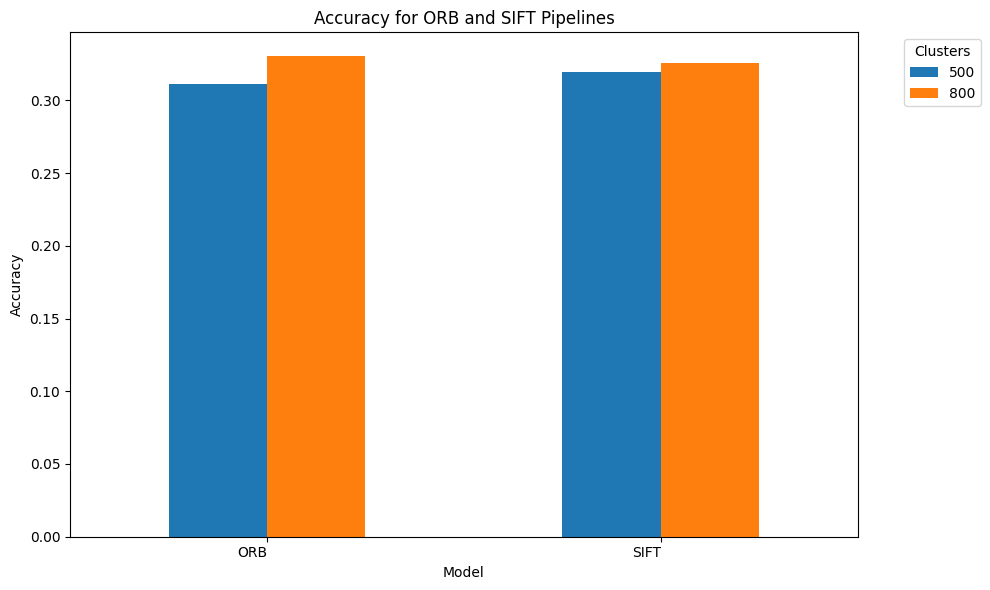

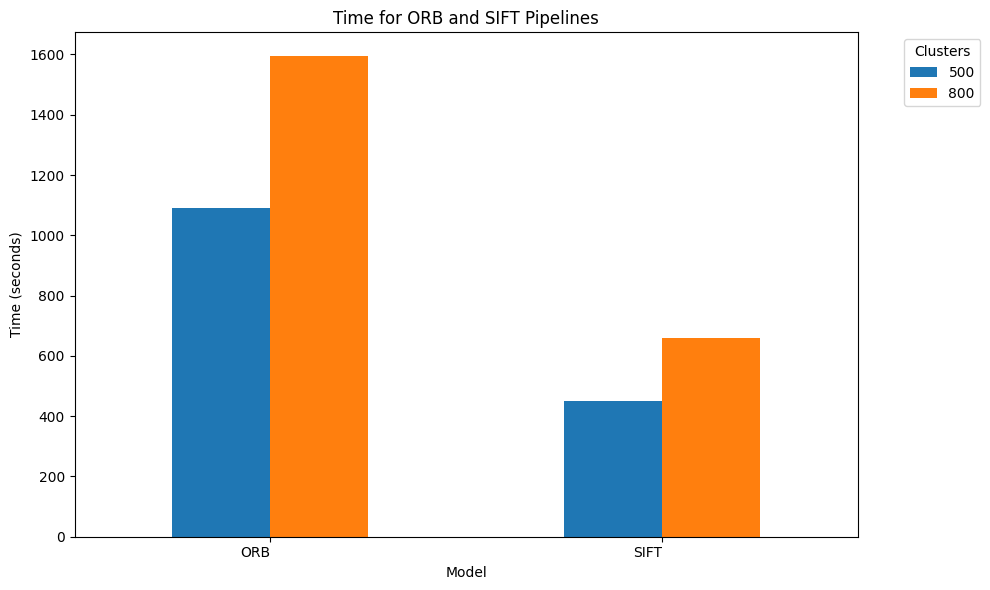

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

df_500 = accuracy_df_1.copy()
df_500['Clusters'] = 500
df_500['Time'] = [1091.935860, 450.765967]


df_800 = accuracy_df.copy()
df_800['Clusters'] = 800

# Concatenate the DataFrames
combined_df = pd.concat([df_500, df_800], ignore_index=True)

# Plot grouped bar chart for Accuracy
accuracy_pivot = combined_df.pivot_table(index='Model', columns='Clusters', values='Accuracy')
ax = accuracy_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Accuracy for ORB and SIFT Pipelines')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
plt.tight_layout()
plt.show()

# Plot grouped bar chart for Time
time_pivot = combined_df.pivot_table(index='Model', columns='Clusters', values='Time')
ax = time_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Time for ORB and SIFT Pipelines')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [51]:
combined_df

,Model,Accuracy,Time,Clusters,time
0,ORB,0.311234,1593.816993,500,1091.935860
1,SIFT,0.319214,659.942067,500,450.765967
2,ORB,0.330264,1593.816993,800,NaN
3,SIFT,0.325353,659.942067,800,NaN


In [48]:
accuracy_df_1

,Model,Accuracy,Time
0,ORB,0.311234,1593.816993
1,SIFT,0.319214,659.942067


In [49]:
accuracy_df

,Model,Accuracy,Time
0,ORB,0.330264,1593.816993
1,SIFT,0.325353,659.942067
